In [1]:
#installs
!pip install fsspec==2023.9.2
!pip install -U datasets
!pip install pandas numpy tensorflow matplotlib torch
!pip install transformers
!pip install tensorflow
!pip install scikit-learn
!pip install librosa
!pip install seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.9.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64

In [2]:
#imports for Machine and Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from scipy.special import rel_entr
from sklearn.model_selection import KFold


import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim


#imports for data science
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor, Wav2Vec2Processor


#other imports
from datasets import load_dataset
import librosa
import random
import os




# DATA PROCESSING

In [3]:
SEED = 42
BATCH_SIZE = 32
FEATURES_PATH = "./features"  # directory to save/load features

TARGET_EMOTIONS = ['happy', 'sad', 'angry', 'neutral']
os.makedirs(FEATURES_PATH, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()


In [4]:
ds = load_dataset("AbstractTTS/IEMOCAP", split="train", download_mode="force_redownload")
ds[0]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/462M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10039 [00:00<?, ? examples/s]

{'file': 'Ses01F_impro01_F000.wav',
 'audio': {'path': 'Ses01F_impro01_F000.wav',
  'array': array([-0.0050354 , -0.00497437, -0.0038147 , ..., -0.00265503,
         -0.00317383, -0.00418091]),
  'sampling_rate': 16000},
 'frustrated': 0.0062500000931322575,
 'angry': 0.0062500000931322575,
 'sad': 0.0062500000931322575,
 'disgust': 0.0062500000931322575,
 'excited': 0.0062500000931322575,
 'fear': 0.0062500000931322575,
 'neutral': 0.949999988079071,
 'surprise': 0.0062500000931322575,
 'happy': 0.0062500000931322575,
 'EmoAct': 2.3333330154418945,
 'EmoVal': 2.6666669845581055,
 'EmoDom': 2.0,
 'gender': 'Female',
 'transcription': ' Excuse me.',
 'major_emotion': 'neutral',
 'speaking_rate': 5.139999866485596,
 'pitch_mean': 202.79881286621094,
 'pitch_std': 76.12785339355469,
 'rms': 0.00788376946002245,
 'relative_db': -17.938434600830078}

In [5]:
TARGET_EMOTIONS = ['happy', 'sad', 'angry', 'neutral']

def normalize_emotion(e):
    if e == 'excited':
        return 'happy'
    return e if e in TARGET_EMOTIONS else None


In [6]:
#LABEL ENCODING
def process_label(example):
    emotion = normalize_emotion(example['major_emotion'])
    if emotion is None:
        return None
    example['label'] = TARGET_EMOTIONS.index(emotion)
    return example

processed_ds = ds.filter(lambda x: normalize_emotion(x['major_emotion']) is not None)
processed_ds = processed_ds.map(process_label)


Filter:   0%|          | 0/10039 [00:00<?, ? examples/s]

Map:   0%|          | 0/6877 [00:00<?, ? examples/s]

# WAVE-2-VEC-2 TRAINING PIPELINE

In [7]:
train_val = processed_ds.train_test_split(test_size=0.2, seed=SEED)
train_dataset_raw = train_val['train']
val_dataset_raw = train_val['test']

In [ ]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-large")
wav2vec2_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-large").to(device)
wav2vec2_model.eval()
for param in wav2vec2_model.parameters():
    param.requires_grad = False

def extract_save_features(dataset, split_name):
    features_file = os.path.join(FEATURES_PATH, f"{split_name}_features.pt")
    labels_file = os.path.join(FEATURES_PATH, f"{split_name}_labels.pt")

    if os.path.exists(features_file) and os.path.exists(labels_file):
        print(f"Loading cached features for {split_name}...")
        features = torch.load(features_file)
        labels = torch.load(labels_file)
        return features, labels

    print(f"Extracting features for {split_name} set...")
    all_features = []
    all_labels = []
    with torch.no_grad():
        for example in dataset:
            audio = example["audio"]["array"]
            inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
            input_values = inputs.input_values.to(device)
            outputs = wav2vec2_model(input_values).last_hidden_state  # (1, seq_len, 1024)
            pooled = torch.mean(outputs, dim=1).squeeze(0)  # (1024,)
            all_features.append(pooled.cpu())
            all_labels.append(example['label'])
    features = torch.stack(all_features)
    labels = torch.tensor(all_labels, dtype=torch.long)
    torch.save(features, features_file)
    torch.save(labels, labels_file)
    return features, labels

train_features, train_labels = extract_save_features(train_dataset_raw, "train")
val_features, val_labels = extract_save_features(val_dataset_raw, "val")


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Extracting features for train set...


model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

In [ ]:
class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]



In [10]:
train_dataset = FeatureDataset(train_features, train_labels)
val_dataset = FeatureDataset(val_features, val_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
class ClassifierHead(nn.Module):
    def __init__(self, num_classes=len(TARGET_EMOTIONS)):
        super(ClassifierHead, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        logits = self.classifier(x)
        return nn.functional.log_softmax(logits, dim=-1)

model = ClassifierHead().to(device)

In [12]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [13]:
def train_epoch():
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        log_probs = model(inputs)
        loss = criterion(log_probs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [14]:
def validate_epoch():
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            log_probs = model(inputs)
            loss = criterion(log_probs, labels)
            total_loss += loss.item()
            preds = log_probs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return total_loss / len(val_loader), accuracy

In [15]:
epochs = 10
for epoch in range(1, epochs + 1):
    train_loss = train_epoch()
    val_loss, val_acc = validate_epoch()
    print(f"Epoch [{epoch}/{epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")
    scheduler.step()

Epoch [1/10] Train Loss: 1.3071 | Val Loss: 1.1879 | Val Accuracy: 0.4949
Epoch [2/10] Train Loss: 1.2029 | Val Loss: 1.1503 | Val Accuracy: 0.4709
Epoch [3/10] Train Loss: 1.1624 | Val Loss: 1.1206 | Val Accuracy: 0.5167
Epoch [4/10] Train Loss: 1.1295 | Val Loss: 1.1169 | Val Accuracy: 0.5276
Epoch [5/10] Train Loss: 1.1287 | Val Loss: 1.0740 | Val Accuracy: 0.5269
Epoch [6/10] Train Loss: 1.1036 | Val Loss: 1.0635 | Val Accuracy: 0.5240
Epoch [7/10] Train Loss: 1.0907 | Val Loss: 1.0817 | Val Accuracy: 0.5073
Epoch [8/10] Train Loss: 1.0721 | Val Loss: 1.0700 | Val Accuracy: 0.4891
Epoch [9/10] Train Loss: 1.0640 | Val Loss: 1.0698 | Val Accuracy: 0.5174
Epoch [10/10] Train Loss: 1.0669 | Val Loss: 1.0580 | Val Accuracy: 0.5131


Validation Accuracy: 51.3081

Classification Report:

              precision    recall  f1-score   support

       happy       0.54      0.47      0.50       511
         sad       0.51      0.71      0.60       242
       angry       0.49      0.77      0.60       272
     neutral       0.50      0.24      0.32       351

    accuracy                           0.51      1376
   macro avg       0.51      0.55      0.50      1376
weighted avg       0.52      0.51      0.49      1376



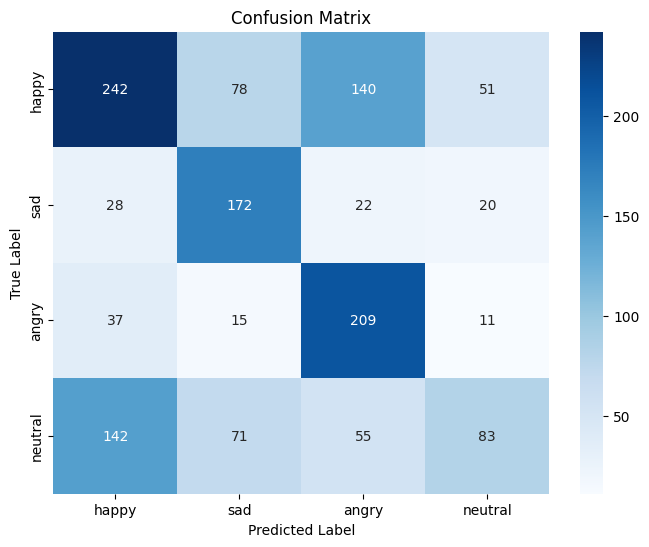

In [20]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        log_probs = model(inputs)
        preds = log_probs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).mean()

print(f"Validation Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=TARGET_EMOTIONS))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=TARGET_EMOTIONS, yticklabels=TARGET_EMOTIONS, cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
